# Working with DataRobot Reason Codes

---

Computing reason codes is a resource-intensive task, but you can help reduce the runtime for computing them by setting prediction value thresholds. You can learn more more details about reason codes searching the online documentation available in the DataRobot web interface (it may be referred to as _Prediction Explanations_ there).

### When are they useful?
A common question when evaluating data is “why is a certain data-point considered high-risk (or low-risk) for a certain event”?

A sample case for reason codes:

>Clark is a business analyst at a large manufacturing firm. She does not have a lot of data science expertise, but has been using DataRobot with great success to predict likely product failures at her manufacturing plant. Her manager is now asking for recommendations for reducing the defect rate, based on these predictions. Clark would like DataRobot to produce reason codes for the expected product failures so that she can identify the key drivers of product failures based on a higher-level aggregation of reasons. Her business team can then use this report to address the causes of failure.

Other common use cases and possible reasons include:

 * What are indicators that a transaction could be at high risk for fraud? Possible reasons include transactions out of a cardholder's home area, transactions out of a “normal” timing range, and transactions that are too large or small.
 * What are some reasons for setting a higher auto insurance price? The applicant is single, male, age under 30 years, and has received tickets. A married homeowner may receive a lower rate.
 
---

## Setup
<div class="alert alert-box alert-info">
<b>Important</b>: this workbook requires that you already have completed the <b>Basic Introduction to DataRobot via API</b> notebook in this series.
</div>

The [intro notebook](Basic Introduction to DataRobot via API.ipynb) should have saved some of the results from your prior work; we will attempt to load those values in now:

In [1]:
import json

with open('intro-notebook-output.json') as fp:
    params = json.load(fp)

# Validate
assert params.get('project-id')
assert params.get('best-model-id')
assert params.get('predict-dataset-id')

### Connecting to DataRobot

To access the DataRobot modeling engine, it is necessary to establish an authenticated connection. The necessary information is an **endpoint** - the URL address of the specific DataRobot server being used - and a **token**, a previously validated access token.

#### Endpoint

In [2]:
endpoint = 'https://app.datarobot.com/api/v2'

#### Token

In [3]:
token = 'YOUR_TOKEN_HERE'

assert token != 'YOUR_TOKEN_HERE'

#### Setting the configuration in code
The next cell will configure the datarobot package to use the provided endpoint and token. This only needs to be done once per session.

In [4]:
import datarobot as dr 
dr.Client(endpoint=endpoint, token=token)

The connection to DataRobot should now be ready.

---
## Getting your project

Load back in the Project and Model objects by using the `ID`s from the other notebook:

In [5]:
project = dr.Project.get(params['project-id'])
project

Project(Airline Delay)

In [6]:
model = dr.Model.get(project.id, params['best-model-id'])
model

Model('ENET Blender')

## Compute Predictions
Another prerequisite to reason codes is the need to have an uploaded dataset which has predictions computed for it. However, the intro notebook should have already done this for us so we will just re-use those predictions:

In the _intro notebook_ we already uploaded a sample prediction dataset so we will just re-use those results here:

In [7]:
%%time
dataset = dr.PredictionDataset.get(project.id, params['predict-dataset-id'])
predict_job = model.request_predictions(dataset.id)
predictions = predict_job.get_result_when_complete(4*60)

CPU times: user 1.19 s, sys: 44 ms, total: 1.23 s
Wall time: 18.9 s


Let's have a look at our results. Since this is a binary classification problem, as the `positive_probability` approaches zero this row is a stronger candidate for the negative class (_the flight will leave on-time_), while as it approaches one, the outcome is more likely to be of the positive class (_the flight will be delayed_). We will plot the positive probability below to get a better understanding of the distribution of the prediction results.

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [9]:
matplotlib.rcParams['figure.figsize'] = (15, 10)  # make charts bigger

Text(0.5,1,'Prediction Distribution')

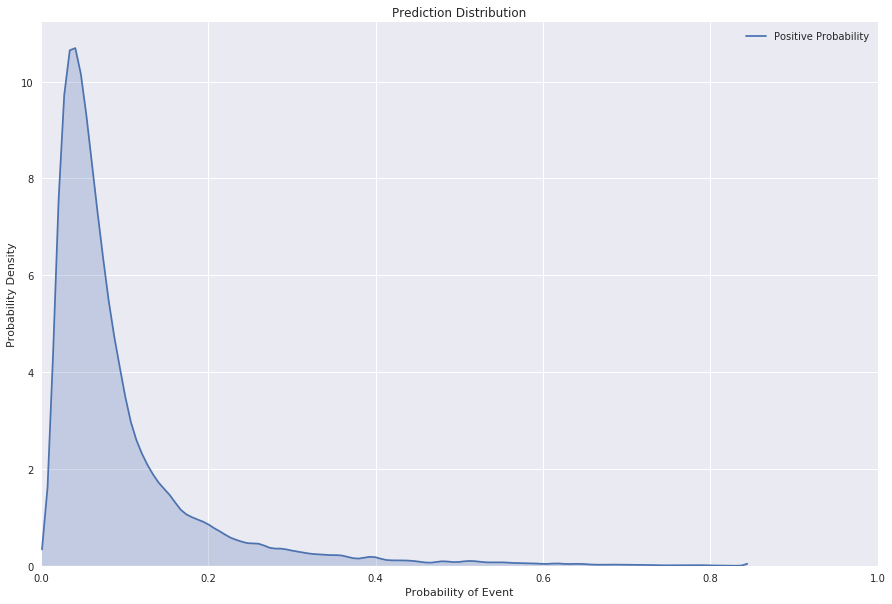

In [10]:
sns.set(color_codes=True)
sns.kdeplot(predictions.positive_probability, shade=True, cut=0, label="Positive Probability")
plt.xlim((0,1))
plt.ylim((0,None))
plt.xlabel('Probability of Event')
plt.ylabel('Probability Density')
plt.title("Prediction Distribution")

## Compute Reason Codes
We are almost ready to compute reason codes. Reason codes require two, one-time (per model) initialization steps.

#### Prerequisite: Feature Impact
A prerequisite to computing reason codes is that you need to compute the **feature impact** for your model (this only needs to be done once per model):

In [11]:
%%time
try:
    impact_job = model.request_feature_impact()
    impact_job.wait_for_completion(4*60)  # wait 4 minutes to compute
except dr.errors.JobAlreadyRequested:
    pass  # already computed

CPU times: user 28 ms, sys: 28 ms, total: 56 ms
Wall time: 97.7 ms


#### Prerequisite: Reason Codes Initialization
After Feature Impact has been computed, you also must create a _Reason Codes Initialization_ for your model:

In [12]:
%%time
try:
    # Test to see if they are already computed
    dr.ReasonCodesInitialization.get(project.id, model.id)
except dr.errors.ClientError as e:
    assert e.status_code == 404  # haven't been computed
    init_job = dr.ReasonCodesInitialization.create(project.id, model.id)
    init_job.wait_for_completion()

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 144 ms


### Computing the reason codes
Now that we have computed the feature impact and initialized the reason codes, and also uploaded a dataset and computed predictions on it, we are ready to make a request to compute the reason codes for every row of the dataset. Computing reason codes supports a couple of parameters:

* `max_codes` are the maximum number of reason codes to compute for each row.
* `threshold_low` and `threshold_high` are thresholds for the value of the prediction of the row. Reason codes will be computed for a row if the row’s prediction value is higher than threshold_high or lower than threshold_low. If no thresholds are specified, reason codes will be computed for **all rows**.

**Note:** for binary classification projects (like this one), the thresholds correspond to the `positive_probability` prediction value whereas for regression problems, it corresponds to the actual predicted value.

Since we've already examined our prediction distribution from above let's use that to influence what we set for our thresholds. It looks like most flights depart on-time so let's just examine the reasons for flights that have an _above normal_ probability for being delayed. We will use a `threshold_high` of `0.456` which means all rows where the predicted `positive_probability` is **at least** `0.456` we will compute the reason codes for that row. For the simplicity of this tutorial, we will also limit DataRobot to only compute `4` codes for us.

In [13]:
%%time
number_of_reasons = 4
rc_job = dr.ReasonCodes.create(project.id, model.id, dataset.id,
                               max_codes=number_of_reasons, 
                               threshold_low=None,
                               threshold_high=0.456)
rc = rc_job.get_result_when_complete()
all_rows = rc.get_all_as_dataframe()

CPU times: user 7.21 s, sys: 52 ms, total: 7.26 s
Wall time: 28.7 s


Let's cleanup the DataFrame we got back by trimming it down to just the interesting columns. Also, since most rows will have prediction values outside our thresholds, let's drop all the uninteresting rows (i.e. ones with `null` values).

In [14]:
import pandas as pd
pd.options.display.max_rows = 10  # default display is too verbose

# These rows are all redundant or of little value for this example
reasons = all_rows.drop(['row_id', 'class_0_label', 'class_1_probability', 'class_1_label'],
                        axis=1)
reasons.drop([f"reason_{i}_label" for i in range(number_of_reasons)],
             axis=1, inplace=True)

# These are rows that didn't meet our thresholds
reasons.dropna(inplace=True)

# Rename columns to be more consistent with the terms we have been using
reasons.rename(index=str, columns={"class_0_probability": "positive_probability"}, inplace=True)
reasons

,prediction,positive_probability,reason_0_feature,reason_0_feature_value,reason_0_qualitative_strength,reason_0_strength,reason_1_feature,reason_1_feature_value,reason_1_qualitative_strength,reason_1_strength,reason_2_feature,reason_2_feature_value,reason_2_qualitative_strength,reason_2_strength,reason_3_feature,reason_3_feature_value,reason_3_qualitative_strength,reason_3_strength
593,1.0,0.505323,daily_rainfall,1.350000e+00,+++,1.074490,Scheduled Departure Time,-2208920400,+++,0.989334,day_of_week,Thurs,++,0.663748,Flight Number,561,--,-0.487189
599,1.0,0.551285,daily_rainfall,1.350000e+00,+++,1.166670,Scheduled Departure Time,-2208918600,+++,1.102931,did_rain,True,++,0.498812,day_of_week,Thurs,++,0.413684
612,1.0,0.569199,Scheduled Departure Time,-2.208915e+09,+++,1.331459,daily_rainfall,1.35,+++,1.259771,day_of_week,Thurs,++,0.536583,Scheduled Departure Time (Hour of Day),20,++,0.328074
893,1.0,0.582619,daily_rainfall,2.500000e-01,+++,1.917284,Scheduled Departure Time,-2208925800,+++,1.146913,Flight Number,728,++,0.378521,did_rain,True,++,0.367195
894,1.0,0.637904,daily_rainfall,2.500000e-01,+++,1.960371,Scheduled Departure Time,-2208918600,+++,1.402661,did_rain,True,++,0.478608,Flight Number,738,++,0.303017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,1.0,0.548005,Scheduled Departure Time,-2.208915e+09,+++,1.166377,daily_rainfall,0.11,++,0.685493,month,7,++,0.495122,Scheduled Departure Time (Hour of Day),20,++,0.407042
18222,1.0,0.501521,Scheduled Departure Time,-2.208927e+09,+++,1.087912,daily_rainfall,0.11,+++,0.851496,month,7,++,0.437626,Destination Airport,CLT,++,0.417019
18256,0.0,0.496702,daily_rainfall,1.100000e-01,+++,1.091645,Scheduled Departure Time,-2208920400,+++,1.005213,did_rain,True,++,0.471879,Scheduled Departure Time (Hour of Day),19,++,0.331153
18392,1.0,0.516543,Scheduled Departure Time,-2.208920e+09,+++,1.176622,month,7,++,0.901168,day_of_week,Thurs,++,0.482601,Tail Number,N170US,++,0.460604


## Explore Reason Code results
Now let's see how often various features are showing up as the top reason for impacting the probability of a flight being delayed.

In [15]:
from functools import reduce

# Create a combined histogram of all our reasons
reasons_hist = reduce(lambda x, y: x.add(y, fill_value=0),
                      (reasons[f"reason_{i}_feature"].value_counts()
                       for i in range(number_of_reasons)))

Text(0.5,1,'Frequency of Features in Top 4 Reason(s)')

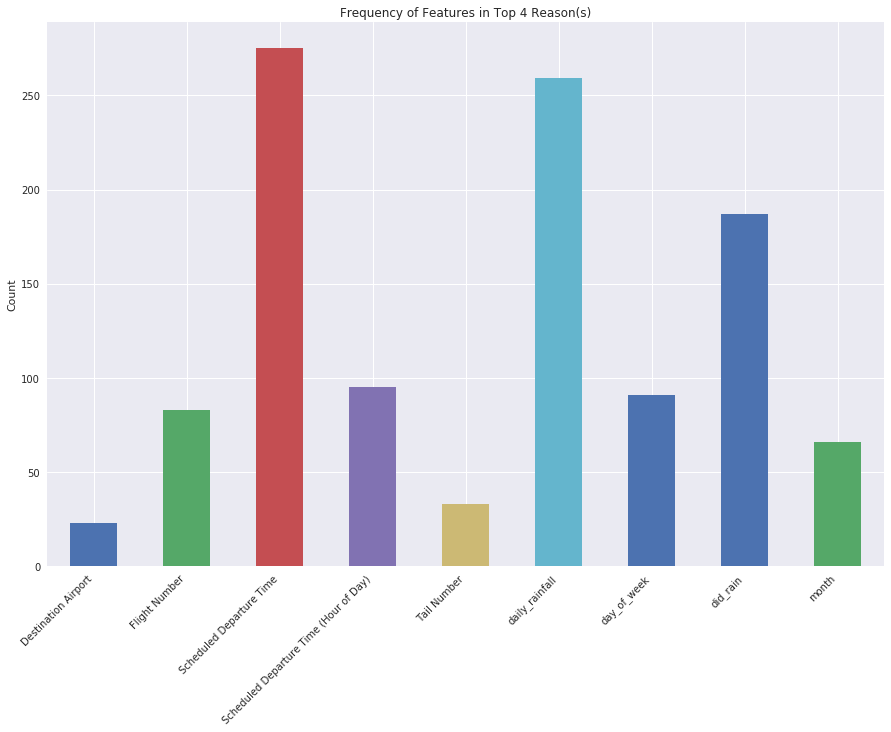

In [16]:
reasons_hist.plot.bar()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title(f"Frequency of Features in Top {number_of_reasons} Reason(s)")

Knowing the _feature impact_ for this model from the _Diving Deeper_ notebook, the high occurrence of the `daily_rainfall` and `Scheduled Departure Time` as reason codes is not entirely surprising because these were some of the top ranked features in the impact chart. Therefore, let's take a small detour investigating some of the rows that had less expected reasons.

---
Below is some helper code. It can largely be ignored as it is mostly relevant for this exercise and not needed for a general understanding of the DataRobot APIs

In [17]:
from operator import or_
from functools import reduce
from itertools import chain

def find_rows_with_reason(df, feature_name, nreasons):
    """
    Given a reason codes DataFrame, return a slice of that data where the
    top N reasons match the given feature
    """
    all_reason_columns = (df[f"reason_{i}_feature"] == feature_name 
                          for i in range(nreasons))
    df_filter = reduce(or_, all_reason_columns)
    return favorite_reason_columns(df[df_filter], nreasons)

def favorite_reason_columns(df, nreasons):
    """
    Only display the most useful rows of a reason codes DataFrame.
    """
    # Use chain to flatten our list of tuples
    columns = list(chain.from_iterable((f"reason_{i}_feature", 
                                        f"reason_{i}_feature_value", 
                                        f"reason_{i}_strength")
                                       for i in range(nreasons)))
    return df[columns]

def find_feature_in_row(feature, row, nreasons):
    """
    Return the value of a given feature
    """
    for i in range(nreasons):
        if row[f"reason_{i}_feature"] == feature:
            return row[f"reason_{i}_feature_value"]
    
def collect_feature_values(df, feature, nreasons):
    """
    Return a list of all values of a given reason code from a DataFrame
    """
    return [find_feature_in_row(feature, row, nreasons)
            for index, row in df.iterrows()]

---

### Investigation: Destination Airport
It looks like there was a small number of rows where the `Destination Airport` was one of the top N reasons for a given prediction

In [18]:
feature_name = 'Destination Airport'
flight_nums = find_rows_with_reason(reasons, feature_name, number_of_reasons)
flight_nums

,reason_0_feature,reason_0_feature_value,reason_0_strength,reason_1_feature,reason_1_feature_value,reason_1_strength,reason_2_feature,reason_2_feature_value,reason_2_strength,reason_3_feature,reason_3_feature_value,reason_3_strength
961,Scheduled Departure Time,-2.208920e+09,1.153575,Flight Number,1788,0.616095,Destination Airport,CLT,0.523957,day_of_week,Thurs,0.446320
1504,Scheduled Departure Time,-2.208920e+09,1.261850,Destination Airport,CLT,0.688756,daily_rainfall,0.16,0.577694,day_of_week,Thurs,0.306210
2258,Scheduled Departure Time,-2.208927e+09,1.600522,daily_rainfall,0.63,1.179723,day_of_week,Thurs,0.432385,Destination Airport,CLT,0.423966
5879,daily_rainfall,2.000000e-01,2.369621,Scheduled Departure Time,-2208947400,0.550506,did_rain,True,0.534186,Destination Airport,PHL,0.237344
6368,Scheduled Departure Time,-2.208920e+09,1.531342,daily_rainfall,0.59,0.884156,Destination Airport,CLT,0.420807,Tail Number,N552UW,-0.364203
...,...,...,...,...,...,...,...,...,...,...,...,...
17638,Scheduled Departure Time,-2.208920e+09,1.171902,month,7,0.838242,day_of_week,Thurs,0.498123,Destination Airport,CLT,0.397920
18015,Scheduled Departure Time,-2.208920e+09,1.366706,month,7,0.908183,Destination Airport,CLT,0.570048,day_of_week,Thurs,0.467912
18208,Scheduled Departure Time,-2.208920e+09,1.313184,daily_rainfall,0.11,1.126847,month,7,0.426474,Destination Airport,CLT,0.408087
18222,Scheduled Departure Time,-2.208927e+09,1.087912,daily_rainfall,0.11,0.851496,month,7,0.437626,Destination Airport,CLT,0.417019


Text(0.5,1,'Histogram of "Destination Airport" Values')

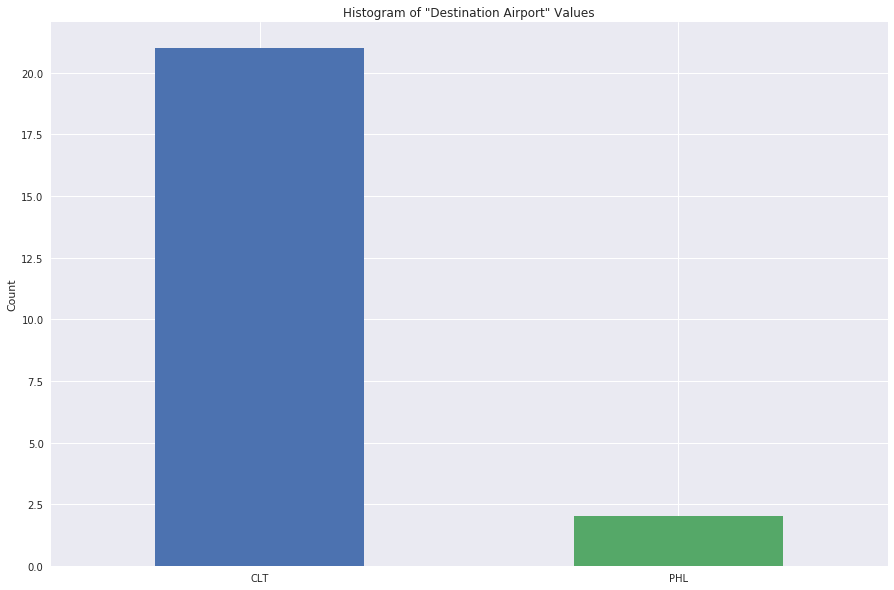

In [19]:
all_flights = collect_feature_values(flight_nums, feature_name, number_of_reasons)
pd.DataFrame(all_flights)[0].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Histogram of "Destination Airport" Values')

Many a frequent flier will tell you horror stories about flying in and out of certain airports. While any given reason code can have a positive **or** a negative impact to a prediction (this is indicated by both the _strength_ and _qualitative&#95;strength_ columns), due to the thresholds we configured earlier for this tutorial it is likely that the above airports are causing flight delays.

---

### Investigation: Scheduled Departure Time
DataRobot correctly identified the `Scheduled Departure Time` input as a timestamp but in the reason code output, we are seeing the internal representation of the time value as a _Unix epoch_ value so let's put it back into a format that humans can understand better:

In [20]:
# For simplicity, let's just look at rows where `Scheduled Departure Time`
# was the first/top reason.
bad_times = reasons[reasons.reason_0_feature == 'Scheduled Departure Time']

# Now let's convert the epoch to a datetime
pd.to_datetime(bad_times.reason_0_feature_value, unit='s')

612     1900-01-01 20:30:00
901     1900-01-01 19:10:00
961     1900-01-01 19:10:00
1021    1900-01-01 19:10:00
1323    1900-01-01 19:10:00
                ...        
18212   1900-01-01 19:30:00
18218   1900-01-01 20:30:00
18222   1900-01-01 17:05:00
18392   1900-01-01 19:10:00
18406   1900-01-01 17:05:00
Name: reason_0_feature_value, Length: 115, dtype: datetime64[ns]

We can see that it appears as though all departures occurred on Jan. 1st, 1900. This is because the original value was simply a _timestamp_ so only the **time portion** of the epoch is meaningful. We will clean this up in our graph below:

Text(0.5,1,'Relationship of Depart Time and being delayed')

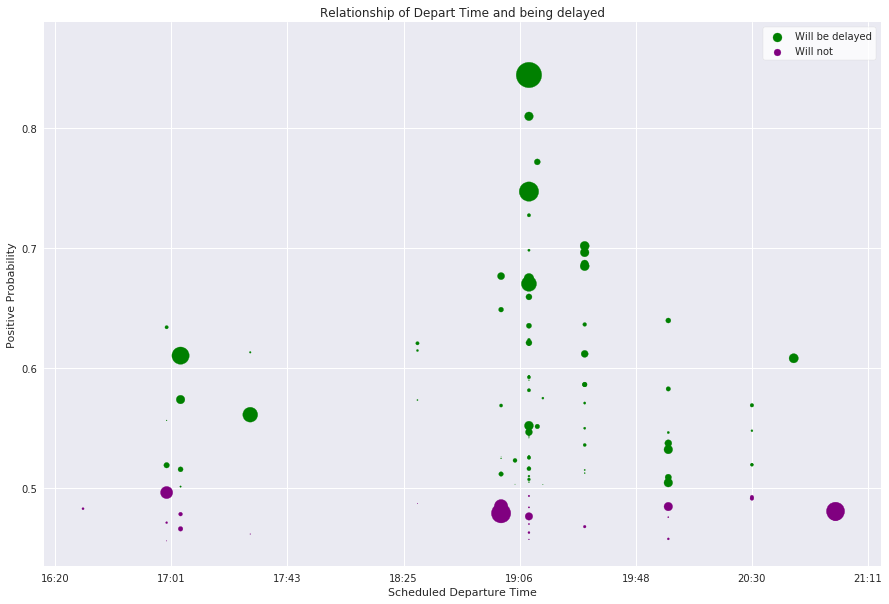

In [21]:
from matplotlib.ticker import FuncFormatter
from time import gmtime, strftime

scale_factor = 9  # make the difference in strengths more visible

depart = reasons[reasons.reason_0_feature == 'Scheduled Departure Time']
true_only = depart[depart.prediction == True]
false_only = depart[depart.prediction == False]
plt.scatter(x=true_only.reason_0_feature_value,
            y=true_only.positive_probability, 
            c='green',
            s=true_only.reason_0_strength ** scale_factor,
            label='Will be delayed')
plt.scatter(x=false_only.reason_0_feature_value,
            y=false_only.positive_probability, 
            c='purple',
            s=false_only.reason_0_strength ** scale_factor,
            label='Will not')

# Convert the Epoch values into human time stamps
formatter = FuncFormatter(lambda x, pos: strftime('%H:%M', gmtime(x)))
plt.gca().xaxis.set_major_formatter(formatter)

plt.xlabel('Scheduled Departure Time')
plt.ylabel('Positive Probability')
plt.legend(markerscale=.5, frameon=True, facecolor="white")
plt.title("Relationship of Depart Time and being delayed")

The above plot shows each prediction where the top influencer of the prediction was the `Scheduled Departure Time`. It's plotted against the `positive_probability` on the Y-axis and the size of the plots represent the strength that departure time had on the prediction (relative to the other features of that given data point). Finally to aid visually, the positive vs. negative outcomes are colored.

As we can see by the time-scale on the X-axis, it doesn't represent the full 24 hours. This is telling. Since we filtered our data earlier to only show predictions that were leaning towards being delayed, and this chart is leaning towards times in the afternoon and evening there may be a correlation between later scheduled departure time and a higher probability of being delayed. With a little bit of domain knowledge, one will understand that an airplane and its crew make many flights in a day (typically hopping between cities) so small delays in the morning compound into the evening hours.

---
## Conclusion
Reason Codes are very useful on a per-prediction row to help give insights into why the model provided the given prediction. Also, as we saw in this tutorial, with some domain knowledge and creativity you can use aggregations of codes to find even deeper insights about your business! 

For more information about Reason Codes, consult the DataRobot documentation linked from the web UI or for specifics relating to the Python API, there is a `Reason Codes` section in the [official documentation](https://datarobot-public-api-client.readthedocs-hosted.com).